# Проект: предсказания победителя в онлайн-игре

# Подход 1: градиентный бустинг "в лоб"

In [48]:
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import auc

%matplotlib inline

features = pd.read_csv('features.csv', index_col='match_id')
r, c = features.shape

# Удаление признаков связанных с результатами матчей
X = features.copy()
X = X.drop([
    'duration',
    'radiant_win',
    'tower_status_radiant',
    'tower_status_dire',
    'barracks_status_radiant',
    'barracks_status_dire'], axis=1)
y = np.ravel(features['radiant_win'])

# Определяем признаки с пропусками и заполняем их нулями
for column in X.columns:
    gap = r - X[column].count()
    if gap > 0:
        print("%s\t%d" % (column, gap))

X = X.fillna(value=0)

first_blood_time	19553
first_blood_team	19553
first_blood_player1	19553
first_blood_player2	43987
radiant_bottle_time	15691
radiant_courier_time	692
radiant_flying_courier_time	27479
radiant_first_ward_time	1836
dire_bottle_time	16143
dire_courier_time	676
dire_flying_courier_time	26098
dire_first_ward_time	1826


In [9]:
# Функция тестирования модели с заданным количеством деревьев и скорости обучения
def model_test(learning_rate=0.5, n_estimators=[10, 20]):
    scores = np.array([])
    for n_est in n_estimators:
        print("n_estimators = %d" % n_est)
        cv = KFold(n_splits=5, shuffle=True, random_state=241)
        model = GradientBoostingClassifier(learning_rate=learning_rate, n_estimators=n_est, random_state=241)
        start_time = datetime.datetime.now()
        score = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
        print 'Time elapsed: ', datetime.datetime.now() - start_time
        print 'Score: ', score
        scores = np.append(scores, score.mean())
    return scores

In [39]:
# Подбор более подходящего значения скорости обучения
scores_ = {}
for learning_rate in [1, 0.5, 0.3, 0.2, 0.1]:
    print("\nTesting model with learning rate %f\n" % learning_rate)
    scores_[learning_rate] = model_test(learning_rate=learning_rate)

# Качество имеет большее значение при скорости обучения = 0.5
# Проверка проводилась на 10 и 20 деревьях.
best_lr = 0
best_lr_x, best_lr_y = 0, 0
for i in xrange(5):
    if scores_.items()[i][1][0] > best_lr_x and scores_.items()[i][1][1] > best_lr_y:
        best_lr_x = scores_.items()[i][1][0]
        best_lr_y = scores_.items()[i][1][1]
        best_lr = scores_.items()[i][0]

print("\nThe best learning rate value is { %f }" % best_lr)


Testing model with learning rate 1.000000

n_estimators = 10
Time elapsed:  0:00:22.546731
Score:  [ 0.68995292  0.67862372  0.67873962  0.68232515  0.68697234]
n_estimators = 20
Time elapsed:  0:00:42.414625
Score:  [ 0.69669337  0.68817387  0.68508549  0.69124587  0.69476796]

Testing model with learning rate 0.500000

n_estimators = 10
Time elapsed:  0:00:23.022546
Score:  [ 0.68914913  0.67871917  0.68166658  0.68268293  0.68826445]
n_estimators = 20
Time elapsed:  0:00:43.671841
Score:  [ 0.69991575  0.69181981  0.69328443  0.69650744  0.70195446]

Testing model with learning rate 0.300000

n_estimators = 10
Time elapsed:  0:00:22.594225
Score:  [ 0.68843653  0.67603488  0.67987841  0.68262608  0.68869448]
n_estimators = 20
Time elapsed:  0:00:42.854931
Score:  [ 0.70112158  0.6903779   0.69384366  0.6930134   0.7003959 ]

Testing model with learning rate 0.200000

n_estimators = 10
Time elapsed:  0:00:22.079408
Score:  [ 0.68348338  0.66939648  0.67607657  0.67597562  0.68153762

In [40]:
# Подбираем оптимальное число деревьев
scores = model_test(n_estimators=[30, 50, 100, 200, 250])

n_estimators = 30
Time elapsed:  0:01:09.019484
Score:  [ 0.7053997   0.69699335  0.6979751   0.7018166   0.70565901]
n_estimators = 50
Time elapsed:  0:01:36.727257
Score:  [ 0.71181897  0.70167028  0.70347427  0.70618343  0.71103276]
n_estimators = 100
Time elapsed:  0:03:10.871323
Score:  [ 0.71541638  0.70792045  0.70617748  0.71129033  0.71575365]
n_estimators = 200
Time elapsed:  0:05:56.425011
Score:  [ 0.71566823  0.71002401  0.7107601   0.71069774  0.71714431]
n_estimators = 250
Time elapsed:  0:07:15.956868
Score:  [ 0.71371971  0.70903301  0.70892526  0.71173471  0.71594359]


In [42]:
model_test(n_estimators=[300, 350])

n_estimators = 300
Time elapsed:  0:08:48.502847
Score:  [ 0.71116831  0.70796453  0.70738595  0.7106641   0.71432084]
n_estimators = 350
Time elapsed:  0:10:00.478707
Score:  [ 0.71091993  0.70697359  0.70577619  0.71055353  0.71397314]


array([ 0.71030075,  0.70963928])

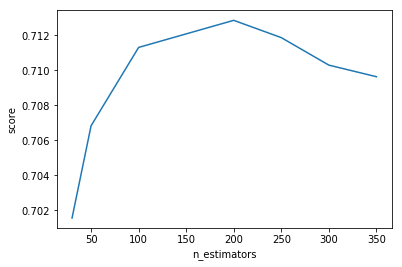

In [49]:
scores__ = np.append(scores, [0.71030075,  0.70963928])

plt.plot([30, 50, 100, 200, 250, 300, 350], scores__)
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.show()

1. Какие признаки имеют пропуски среди своих значений? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?<br>
Следующие признаки имеют пропуски среди своих значений (Признак : количество пропусков):<br>
first_blood_time : 19553<br>
first_blood_team : 19553<br>
first_blood_player1 : 19553<br>
first_blood_player2 : 43987<br>
radiant_bottle_time : 15691<br>
radiant_courier_time : 692<br>
radiant_flying_courier_time : 27479<br>
radiant_first_ward_time : 1836<br>
dire_bottle_time : 16143<br>
dire_courier_time : 676<br>
dire_flying_courier_time : 26098<br>
dire_first_ward_time : 1826<br>
<br>
Признак first\_blood\_time - это игровое время первой крови. "Первая кровь", как событие, может не произойти в первые пять минут игры, тогда оно примет пропущенное значение. Этим могут объясняться пропуски в остальных признаках "первой крови".<br>
Признак first\_blood\_player2 - это второй игрок, причастный к событию "первой крови". Данное событие может происходить с участием только одного игрока, тогда значение причастности второго будет пропуском.<br>
Признаки (radiant|dire)\_bottle\_time - время первого приобретения командой предмета "bottle". Команды могут не купить за первые 5 минут данный предмет, тогда значение будет пропуском.<br>
<br>
2. Как называется столбец, содержащий целевую переменную?<br>
radiant_win<br>
<br>
3. Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Какое качество при этом получилось? <br>
Кросс-валидация для градиентного бустинга с 30 деревьями проводилась 0:01:09, с качеством AUC-ROC 0.70.<br>
<br>
4. Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?<br>
Да, имеет смысл использовать более 30 деревьев, примерно около 200, т.к. качество при большем количестве деревьев растет. При количестве деревьев более 200 качество начинает падать.<br>
50 деревьев - качество 0.70683594<br>
100 деревьев - качество 0.71131166<br>
**200 деревьев - качество 0.71285888**<br>
250 деревьев - качество 0.71187126<br>
300 деревьев - качество 0.71030075<br>
350 деревьев - качество 0.70963928<br>
<br>
Для усорения обучения можно сократить глубину строящихся деревьев (max_depth), также можно обучаться не на всей выборке, а использовать только часть от неё.

In [52]:
pd.set_option('display.max_columns', None)
X.describe()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_hero,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_hero,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_hero,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_hero,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,r5_deaths,r5_items,d1_hero,d1_level,d1_xp,d1_gold,d1_lh,d1_kills,d1_deaths,d1_items,d2_hero,d2_level,d2_xp,d2_gold,d2_lh,d2_kills,d2_deaths,d2_items,d3_hero,d3_level,d3_xp,d3_gold,d3_lh,d3_kills,d3_deaths,d3_items,d4_hero,d4_level,d4_xp,d4_gold,d4_lh,d4_kills,d4_deaths,d4_items,d5_hero,d5_level,d5_xp,d5_gold,d5_lh,d5_kills,d5_deaths,d5_items,first_blood_time,first_blood_team,first_blood_player1,first_blood_player2,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
count,9.723000e+04,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000
mean,1.444232e+09,2.630999,51.517104,3.442672,1233.405801,1147.899702,11.231996,0.357009,0.362285,8.271315,52.183452,3.364661,1189.223676,1107.863993,10.471747,0.348709,0.363550,8.275584,52.710491,3.353924,1182.879965,1099.643742,10.333004,0.342723,0.357338,8.273527,52.648092,3.308896,1159.088481,1082.090240,9.981909,0.337746,0.357307,8.275049,52.625630,3.304237,1158.586167,1082.057061,9.995351,0.337262,0.352782,8.288491,51.990106,3.461123,1238.855765,1151.018184,11.253841,0.372262,0.344091,8.296380,52.708547,3.388933,1199.858809,1108.633436,10.460424,0.356238,0.347012,8.310419,52.755137,3.378638,1193.554438,1103.273702,10.386918,0.353533,0.347732,8.305420,52.922421,3.337725,1171.952155,1088.711653,10.035349,0.354952,0.341860,8.319665,53.059694,3.345274,1177.395351,1089.558850,10.053739,0.356063,0.342538,8.323048,78.042919,0.416878,3.669732,2.400247,106.337200,-79.489715,154.945161,2.994775,3.312527,2.431719,0.716250,-6.745912,106.093644,-79.634352,157.196040,2.965566,3.349553,2.448339,0.689119,-6.772303
std,5.515393e+06,2.835761,32.564211,1.111741,566.588895,464.111662,9.041620,0.663889,0.626704,2.497575,32.674077,1.097536,555.363510,458.001007,8.972073,0.654060,0.624236,2.433864,32.560923,1.092126,554.899600,454.727127,8.950871,0.647774,0.618071,2.440139,32.670519,1.092502,550.937530,450.353291,8.917997,0.642908,0.616181,2.427832,32.608231,1.095842,553.020429,453.165214,8.948413,0.643538,0.614965,2.430826,32.442153,1.104905,560.550962,459.111207,9.007098,0.678321,0.609487,2.472106,32.500960,1.088991,551.118181,450.268322,8.889886,0.65938